# Step 1: Split the dataset into training and testing sets.

In [71]:
# read audio files
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt

angry_audio_folder = './data_folder/angry'
angry_audio_files = os.listdir(angry_audio_folder)[:100] # Gets first 100 angry audio files
angry_data = []
for angry_audio_file in angry_audio_files:
    audio_path = os.path.join(angry_audio_folder, angry_audio_file)
    y, sr = librosa.load(audio_path, sr=None)
    temp = [y, sr]
    angry_data.append(temp)

fear_audio_folder = './data_folder/fear'
fear_audio_files = os.listdir(fear_audio_folder)[:100] # Gets first 100 fear audio files
fear_data = []
for angry_audio_file in angry_audio_files:
    audio_path = os.path.join(angry_audio_folder, angry_audio_file)
    y, sr = librosa.load(audio_path, sr=None)
    temp = [y, sr]
    fear_data.append(temp)

happy_audio_folder = './data_folder/happy'
happy_audio_files = os.listdir(happy_audio_folder)[:100] # Gets first 100 happy audio files
happy_data = []
for angry_audio_file in angry_audio_files:
    audio_path = os.path.join(angry_audio_folder, angry_audio_file)
    y, sr = librosa.load(audio_path, sr=None)
    temp = [y, sr]
    happy_data.append(temp)

sad_audio_folder = './data_folder/sad'
sad_audio_files = os.listdir(sad_audio_folder)[:100] # Gets first 100 sad audio files
sad_data = []
for angry_audio_file in angry_audio_files:
    audio_path = os.path.join(angry_audio_folder, angry_audio_file)
    y, sr = librosa.load(audio_path, sr=None)
    temp = [y, sr]
    sad_data.append(temp)


In [72]:
from sklearn.model_selection import train_test_split
import pandas as pd

# # Create a list of labels for each audio file
# angry_labels = [0] * len(angry_data) * 12 # 0 = angry
# fear_labels = [1] * len(fear_data) * 12 # 1 = fear
# happy_labels = [2] * len(happy_data) * 12 # 2 = happy
# sad_labels = [3] * len(sad_data) * 12 # 3 = sad

# Create a list of labels for each audio file
angry_labels = [0] * len(angry_data) # 0 = angry
fear_labels = [1] * len(fear_data) # 1 = fear
happy_labels = [2] * len(happy_data) # 2 = happy
sad_labels = [3] * len(sad_data) # 3 = sad

# Concatenate all the data and labels
X = np.concatenate((angry_data, fear_data, happy_data, sad_data))
y = np.concatenate((angry_labels, fear_labels, happy_labels, sad_labels))

# max_len = max(len(sample[0]) for sample in X)
# print(X)

# temp = [[librosa.util.pad_center(data=sample[0], size=max_len), sample[1]] for sample in X]
# X = np.array(temp)
# print(X)

df = pd.DataFrame()
df['Data'] = pd.DataFrame(X)[0]
# print(X)
df['Emotions'] = y
print(df)

                                                  Data  Emotions
0    [0.00015258789, 0.00064086914, 0.0005493164, -...         0
1    [0.00012207031, -0.00045776367, -0.000579834, ...         0
2    [0.0, -0.0007019043, -0.0010986328, -0.0008850...         0
3    [0.00015258789, -3.0517578e-05, -0.0002746582,...         0
4    [0.0, -0.00012207031, 0.0, -3.0517578e-05, -0....         0
..                                                 ...       ...
395  [0.0, 6.1035156e-05, -9.1552734e-05, -0.000183...         3
396  [0.0002746582, 0.00024414062, 0.00024414062, -...         3
397  [-0.0005187988, 6.1035156e-05, -0.00024414062,...         3
398  [0.0, -0.00012207031, -0.00076293945, -0.00027...         3
399  [0.00033569336, -6.1035156e-05, -0.0006713867,...         3

[400 rows x 2 columns]


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# Step 2: Exploratory Data Analysis.

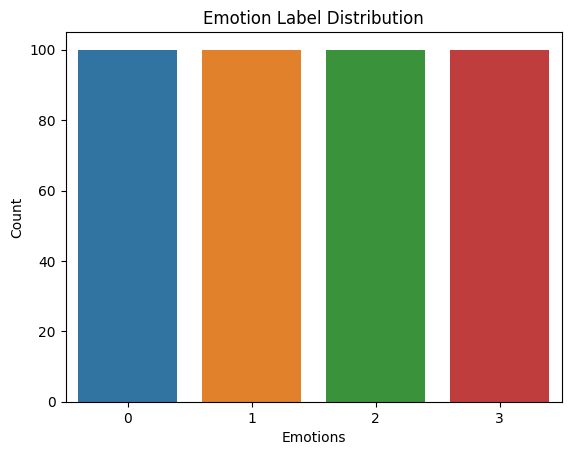

In [73]:
# label distribution
import seaborn as sns

sns.countplot(x=y)
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Emotion Label Distribution")
plt.show()


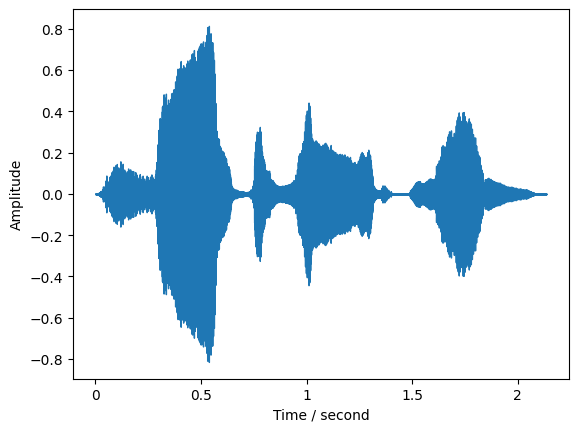

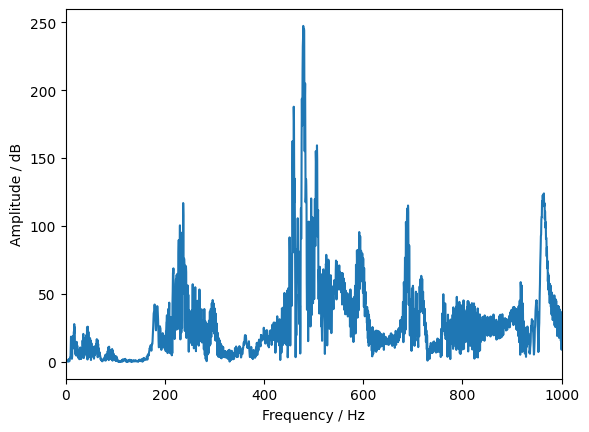

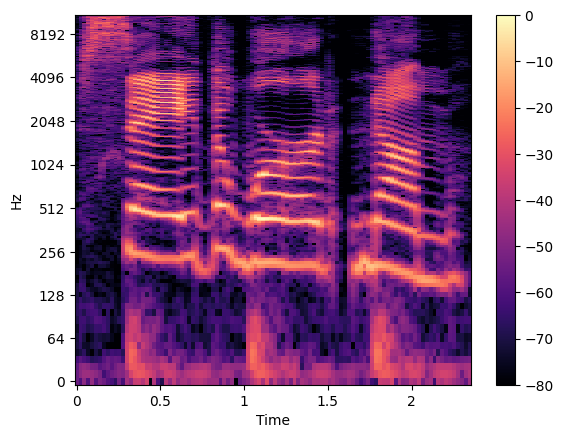

In [74]:
# select one audio file
signal = X[0][0]
sample_rate = X[0][1]

# following code from Professor Ma's extract_audio_features.py example
# plot audio files in time domain
plt.figure(1)
librosa.display.waveshow(y=signal, sr=sample_rate)
plt.xlabel('Time / second')
plt.ylabel('Amplitude')
plt.show()

# plot audio files in frequency domain
k = np.arange(len(signal))
T = len(signal)/sample_rate
freq = k/T

DATA_0 = np.fft.fft(signal)
abs_DATA_0 = abs(DATA_0)
plt.figure(2)
plt.plot(freq, abs_DATA_0)
plt.xlabel("Frequency / Hz")
plt.ylabel("Amplitude / dB")
plt.xlim([0, 1000])
plt.show()


# plot the time-frequency variation of the audio
D = librosa.stft(signal)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure(3)
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

# Step 3: Acoustic Feature Extraction.

In [75]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

def extract_loudness(df, win_length: int):
  signal = df['Data']
  sample_rate = 24414

  # audio feature extraction: loudness
  df_loudness = pd.DataFrame()
  S, phase = librosa.magphase(librosa.stft(y=signal, win_length=win_length))
  rms = librosa.feature.rms(S=S)
  df_loudness['Loudness'] = rms[0]
  df_loudness['Loudness'] = scaler.fit_transform(pd.DataFrame(df_loudness['Loudness']))

  df_loudness['Emotions'] = df['Emotions']

  return df_loudness[['Loudness', 'Emotions']]

def extract_mfccs(df, win_length: int):
  signal = df['Data']
  sample_rate = 24414

  # audio feature extraction: mel-frequency cepstral coefficients
  df_mfccs = pd.DataFrame()
  mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12, win_length=win_length)
  for n_mfcc in range(len(mfccs)):
    df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs[n_mfcc]
    df_mfccs['MFCC_%d'%(n_mfcc+1)] = scaler.fit_transform(pd.DataFrame(df_mfccs['MFCC_%d'%(n_mfcc+1)]))

  df_mfccs['Emotions'] = df['Emotions']

  return df_mfccs[['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'Emotions']]

def extract_zcr(df, win_length: int):
  signal = df['Data']
  sample_rate = 24414

  # audio feature extraction: zero-crossing rate
  df_zcr = pd.DataFrame()
  zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=win_length)
  df_zcr['ZCR'] = zcr[0]
  df_zcr['ZCR'] = scaler.fit_transform(pd.DataFrame(df_zcr['ZCR']))

  df_zcr['Emotions'] = df['Emotions']

  return df_zcr[['ZCR', 'Emotions']]

def extract_chroma(df, win_length: int):
  signal = df['Data']
  sample_rate = 24414

  # audio feature extraction: chroma
  df_chroma = pd.DataFrame()
  chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate, win_length=win_length)
  for n_chroma in range(len(chromagram)):
    df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]
    df_chroma['Chroma_%d'%(n_chroma+1)] = scaler.fit_transform(pd.DataFrame(df_chroma['Chroma_%d'%(n_chroma+1)]))

  df_chroma['Emotions'] = df['Emotions']

  return df_chroma[['Chroma_1', 'Chroma_2', 'Chroma_3', 'Chroma_4', 'Chroma_5', 'Chroma_6', 'Chroma_7', 'Chroma_8', 'Chroma_9', 'Chroma_10', 'Chroma_11', 'Chroma_12', 'Emotions']]

def extract_mel_spectrogram(df, win_length: int):
  signal = df['Data']
  sample_rate = 24414

  # audio feature extraction: mel spectrogram
  df_mel_spectrogram = pd.DataFrame()
  mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12, win_length=win_length)
  for n_mel in range(len(mel_spectrogram)):
    df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]
    df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = scaler.fit_transform(pd.DataFrame(df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)]))

  df_mel_spectrogram['Emotions'] = df['Emotions']

  return df_mel_spectrogram[['Mel_Spectrogram_1', 'Mel_Spectrogram_2', 'Mel_Spectrogram_3', 'Mel_Spectrogram_4', 'Mel_Spectrogram_5', 'Mel_Spectrogram_6', 'Mel_Spectrogram_7', 'Mel_Spectrogram_8', 'Mel_Spectrogram_9', 'Mel_Spectrogram_10', 'Mel_Spectrogram_11', 'Mel_Spectrogram_12', 'Emotions']]

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

def feature_extraction(df, win_length : int):

  signal = df['Data']
  sample_rate = 24414

  # audio feature extraction: loudness
  df_loudness = pd.DataFrame()
  S, phase = librosa.magphase(librosa.stft(y=signal, win_length=win_length))
  rms = librosa.feature.rms(S=S)
  df_loudness['Loudness'] = rms[0]
  df_loudness['Loudness'] = scaler.fit_transform(pd.DataFrame(df_loudness['Loudness']))

  # audio feature extraction: mel-frequency cepstral coefficients
  df_mfccs = pd.DataFrame()
  mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12, win_length=win_length)
  for n_mfcc in range(len(mfccs)):
    df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]
    df_mfccs['MFCC_%d'%(n_mfcc+1)] = scaler.fit_transform(pd.DataFrame(df_mfccs['MFCC_%d'%(n_mfcc+1)]))

  # audio feature extraction: zero-crossing rate
  df_zcr = pd.DataFrame()
  zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=win_length)
  df_zcr['ZCR'] = zcr[0]
  df_zcr['ZCR'] = scaler.fit_transform(pd.DataFrame(df_zcr['ZCR']))

  # audio feature extraction: chroma
  df_chroma = pd.DataFrame()
  chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate, win_length=win_length)
  for n_chroma in range(len(chromagram)):
    df_chroma['Chroma_%d'%(n_chroma+1)] = chromagram.T[n_chroma]
    df_chroma['Chroma_%d'%(n_chroma+1)] = scaler.fit_transform(pd.DataFrame(df_chroma['Chroma_%d'%(n_chroma+1)]))

  # audio feature extraction: mel spectrogram
  df_mel_spectrogram = pd.DataFrame()
  mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12, win_length=win_length)
  for n_mel in range(len(mel_spectrogram)):
    df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]
    df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = scaler.fit_transform(pd.DataFrame(df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)]))
  
  # combining all the features
  feature_matrix = pd.concat([df_loudness.head(12), df_mfccs, df_zcr.head(12), df_chroma, df_mel_spectrogram], axis=1)
  temp = pd.DataFrame()
  temp['Loudness'] = df_loudness.mean(axis=1).head(12)
  temp[['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12']] = df_mfccs.mean(axis=1)
  temp['ZCR'] = df_zcr.mean(axis=1)
  temp[['Chroma_1', 'Chroma_2', 'Chroma_3', 'Chroma_4', 'Chroma_5', 'Chroma_6', 'Chroma_7', 'Chroma_8', 'Chroma_9', 'Chroma_10', 'Chroma_11', 'Chroma_12']] = df_chroma.mean(axis=1)
  temp[['Mel_Spectrogram_1', 'Mel_Spectrogram_2', 'Mel_Spectrogram_3', 'Mel_Spectrogram_4', 'Mel_Spectrogram_5', 'Mel_Spectrogram_6', 'Mel_Spectrogram_7', 'Mel_Spectrogram_8', 'Mel_Spectrogram_9', 'Mel_Spectrogram_10', 'Mel_Spectrogram_11', 'Mel_Spectrogram_12']] = df_mel_spectrogram.mean(axis=1)
  temp['Emotions'] = df['Emotions']
  # print(temp)
  feature_matrix['Mean'] = feature_matrix.mean(axis=1)
  feature_matrix['Emotions'] = df['Emotions']

  return temp

# Step 4: Feature Post-processing.

In [83]:

new_df = pd.DataFrame()
for index, row in df.iterrows():
  new_df = pd.concat([new_df, feature_extraction(row, 1024)])

print(new_df)

    Loudness  MFCC_1    MFCC_2    MFCC_3    MFCC_4    MFCC_5    MFCC_6   
0  -0.998351    -1.0  0.384264  0.958871  0.710454  0.873911  0.876904  \
1  -0.986849    -1.0  0.384264  0.958871  0.710454  0.873911  0.876904   
2  -0.964127    -1.0  0.384264  0.958871  0.710454  0.873911  0.876904   
3  -0.921234    -1.0  0.384264  0.958871  0.710454  0.873911  0.876904   
4  -0.848093    -1.0  0.384264  0.958871  0.710454  0.873911  0.876904   
..       ...     ...       ...       ...       ...       ...       ...   
7  -0.691280    -1.0  0.428012  0.975419  0.713173  0.877658  0.861155   
8  -0.643742    -1.0  0.428012  0.975419  0.713173  0.877658  0.861155   
9  -0.638706    -1.0  0.428012  0.975419  0.713173  0.877658  0.861155   
10 -0.684319    -1.0  0.428012  0.975419  0.713173  0.877658  0.861155   
11 -0.656769    -1.0  0.428012  0.975419  0.713173  0.877658  0.861155   

      MFCC_7    MFCC_8    MFCC_9  ...  Mel_Spectrogram_4  Mel_Spectrogram_5   
0   0.887914  0.897506  0.843665

# Step 5: Build your audio emotion recognition model. 

In [84]:
# Import classifiers and metrics from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

neigh = KNeighborsClassifier(n_neighbors=3)
svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()

In [85]:
X = new_df.drop(['Emotions'], axis=1).to_numpy()
y = new_df['Emotions'].to_numpy()

# print(new_df.drop(['Emotions'], axis=1).to_numpy())
# print(y,X)
# y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# print(X_test)
# print(y_test)

neigh.fit(X_train, y_train)
svc.fit(X_train, y_train)
nbc.fit(X_train, y_train)
rfc.fit(X_train, y_train)


RandomForestClassifier()

# Step 6: Model evaluation.

In [86]:
y_neigh_predicted = neigh.predict(X_test)
y_svc_predicted = svc.predict(X_test)
y_nbc_predicted = nbc.predict(X_test)
y_rfc_predicted = rfc.predict(X_test)

In [87]:
print("K Nearest Neighbors")
print(classification_report(y_test, y_neigh_predicted))
print("Support Vector Classifier")
print(classification_report(y_test, y_svc_predicted))
print("Gaussian Naive Bayes")
print(classification_report(y_test, y_nbc_predicted))
print("Random Forest Classifier")
print(classification_report(y_test, y_rfc_predicted))


K Nearest Neighbors
              precision    recall  f1-score   support

           0       0.09      0.21      0.13       360
           1       0.06      0.07      0.06       360
           2       0.02      0.01      0.01       360
           3       0.03      0.01      0.02       360

    accuracy                           0.07      1440
   macro avg       0.05      0.07      0.05      1440
weighted avg       0.05      0.07      0.05      1440

Support Vector Classifier
              precision    recall  f1-score   support

           0       0.24      0.15      0.18       360
           1       0.23      0.38      0.28       360
           2       0.22      0.24      0.23       360
           3       0.18      0.11      0.13       360

    accuracy                           0.22      1440
   macro avg       0.21      0.22      0.21      1440
weighted avg       0.21      0.22      0.21      1440

Gaussian Naive Bayes
              precision    recall  f1-score   support

        

In [ ]:
def train_and_evaluate(feature : str):
    print("Feature Extraction: ", feature)
    X = new_df.drop(['Emotions'], axis=1).to_numpy()
    y = new_df['Emotions'].to_numpy()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    neigh.fit(X_train, y_train)
    svc.fit(X_train, y_train)
    nbc.fit(X_train, y_train)
    rfc.fit(X_train, y_train)

    y_neigh_predicted = neigh.predict(X_test)
    y_svc_predicted = svc.predict(X_test)
    y_nbc_predicted = nbc.predict(X_test)
    y_rfc_predicted = rfc.predict(X_test)

    print("K Nearest Neighbors")
    print(classification_report(y_test, y_neigh_predicted))
    print("Support Vector Classifier")
    print(classification_report(y_test, y_svc_predicted))
    print("Gaussian Naive Bayes")
    print(classification_report(y_test, y_nbc_predicted))
    print("Random Forest Classifier")
    print(classification_report(y_test, y_rfc_predicted))

In [ ]:

# new_df = pd.DataFrame()
# for index, row in df.iterrows():
#   new_df = pd.concat([new_df, extract_loudness(row, 1024)])
# train_and_evaluate("Loudness")

new_df = pd.DataFrame()
for index, row in df.iterrows():
  new_df = pd.concat([new_df, extract_mfccs(row, 1024)])
train_and_evaluate("MFCC")

# new_df = pd.DataFrame()
# for index, row in df.iterrows():
#   new_df = pd.concat([new_df, extract_zcr(row, 1024)])
# train_and_evaluate("Zero Crossing Rate")

# new_df = pd.DataFrame()
# for index, row in df.iterrows():
#   new_df = pd.concat([new_df, extract_chroma(row, 1024)])
# train_and_evaluate("Chroma")

# new_df = pd.DataFrame()
# for index, row in df.iterrows():
#   new_df = pd.concat([new_df, extract_mel_spectrogram(row, 1024)])
# train_and_evaluate("Mel Spectrogram")

